In [1]:
import os
import numpy as np
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import segmentation_models_pytorch as smp
import albumentations as A  
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, input_dir, output_dir, is_train, transform=None):
        self.input_dir  = input_dir
        self.output_dir = output_dir
        self.transform  = transform
        if is_train == True:
            # x = round(len(os.listdir(input_dir)) * .8)
            self.images = os.listdir(input_dir)
        else:
            # x = round(len(os.listdir(input_dir)) * .8)
            self.images = os.listdir(input_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path    = os.path.join(self.input_dir, self.images[index])
        mask_path   = os.path.join(self.output_dir, self.images[index])
        img         = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32) / 255
        mask        = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)   / 255
        
        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img   = augmentations["image"]
            mask  = augmentations["mask"]
        
        return img, mask

In [4]:
TRAIN_INP_DIR = '/data1/vinod/mitosis/data/processed/train/input'
TRAIN_OUT_DIR = '/data1/vinod/mitosis/data/processed/train/output'
VAL_INP_DIR = '/data1/vinod/mitosis/data/processed/val/input'
VAL_OUT_DIR = '/data1/vinod/mitosis/data/processed/val/output'
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
LEARNING_RATE = 3e-4
BATCH_SIZE    = 8
NUM_EPOCHS    = 3
IMAGE_HEIGHT  = 512  
IMAGE_WIDTH   = 512  

In [6]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.ColorJitter(p=0.2),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2(),
    ],
)

In [7]:
def get_loaders( inp_dir_t, mask_dir_t, inp_dir_v, mask_dir_v, batch_size,train_transform, val_tranform ):
    
    train_ds     = SegmentationDataset( input_dir=inp_dir_t, output_dir=mask_dir_t,
                            is_train=True, transform=train_transform)

    train_loader = DataLoader( train_ds, batch_size=batch_size, shuffle=True )

    val_ds       = SegmentationDataset( input_dir=inp_dir_v, output_dir=mask_dir_v,
                            is_train=False, transform=val_transform)

    val_loader   = DataLoader( val_ds, batch_size=batch_size, shuffle=True  )

    return train_loader, val_loader

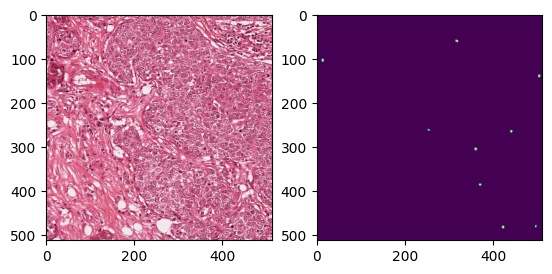

In [8]:
train_loader, val_loader = get_loaders( TRAIN_INP_DIR, TRAIN_OUT_DIR, VAL_INP_DIR, VAL_OUT_DIR, BATCH_SIZE,  train_transform, val_transform)
inputs, masks = next(iter(train_loader))

_, ax = plt.subplots(1,2)
ax[0].imshow(inputs[0].permute(1,2,0))
ax[1].imshow(masks[0])

In [9]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels  = 0
    dice_score  = 0
    iou_score = 0
    model.eval()

    with torch.no_grad():
        for img, mask in tqdm(loader):
            img   = img.to(device)
            mask  = mask.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(img))
            preds = (preds > 0.5).float()
            num_correct += (preds == mask).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * mask).sum()) / (
                (preds + mask).sum() + 1e-7
            )
            intersection = (preds * mask).sum()
            union = (preds + mask).sum()
            iou_score += (intersection + 1e-7) / (union + 1e-7)


    print(f"Got {num_correct}/{num_pixels} with pixel accuracy {num_correct/num_pixels*100:.2f}", flush=True)
    print(f"Dice score: {dice_score/len(loader)*100:.2f}", flush=True)
    print(f"IoU score: {iou_score/len(loader)*100:.2f}", flush=True)

    model.train()

In [10]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [11]:
model = smp.Unet(encoder_name='efficientnet-b3', in_channels=3, classes=1, activation=None).to(DEVICE)
loss_fn   = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [12]:
def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)

    for batch_idx, (image, mask) in enumerate(loop):
        image   = image.to(device=DEVICE)
        mask    = mask.float().unsqueeze(1).to(device=DEVICE)

        # forward
        predictions = model(image)
        loss = loss_fn(predictions, mask)

        # backward
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [13]:
check_accuracy(val_loader, model, device=DEVICE)

100%|██████████| 3/3 [00:05<00:00,  1.71s/it]

Got 151543/4980736 with pixel accuracy 3.04
Dice score: 0.21
IoU score: 0.10


In [14]:
for epoch in range(NUM_EPOCHS):

    print('########################## epoch: '+str(epoch))
    train_fn(train_loader, model, optimizer, loss_fn)
    
    # check accuracy
    check_accuracy(val_loader, model, device=DEVICE)

########################## epoch: 0


100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

Got 1201078/4980736 with pixel accuracy 24.11
Dice score: 0.14
IoU score: 0.07


########################## epoch: 1


100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

Got 4365683/4980736 with pixel accuracy 87.65
Dice score: 0.44
IoU score: 0.22


########################## epoch: 2


100%|██████████| 3/3 [00:02<00:00,  1.00it/s]

Got 4918028/4980736 with pixel accuracy 98.74
Dice score: 0.32
IoU score: 0.16


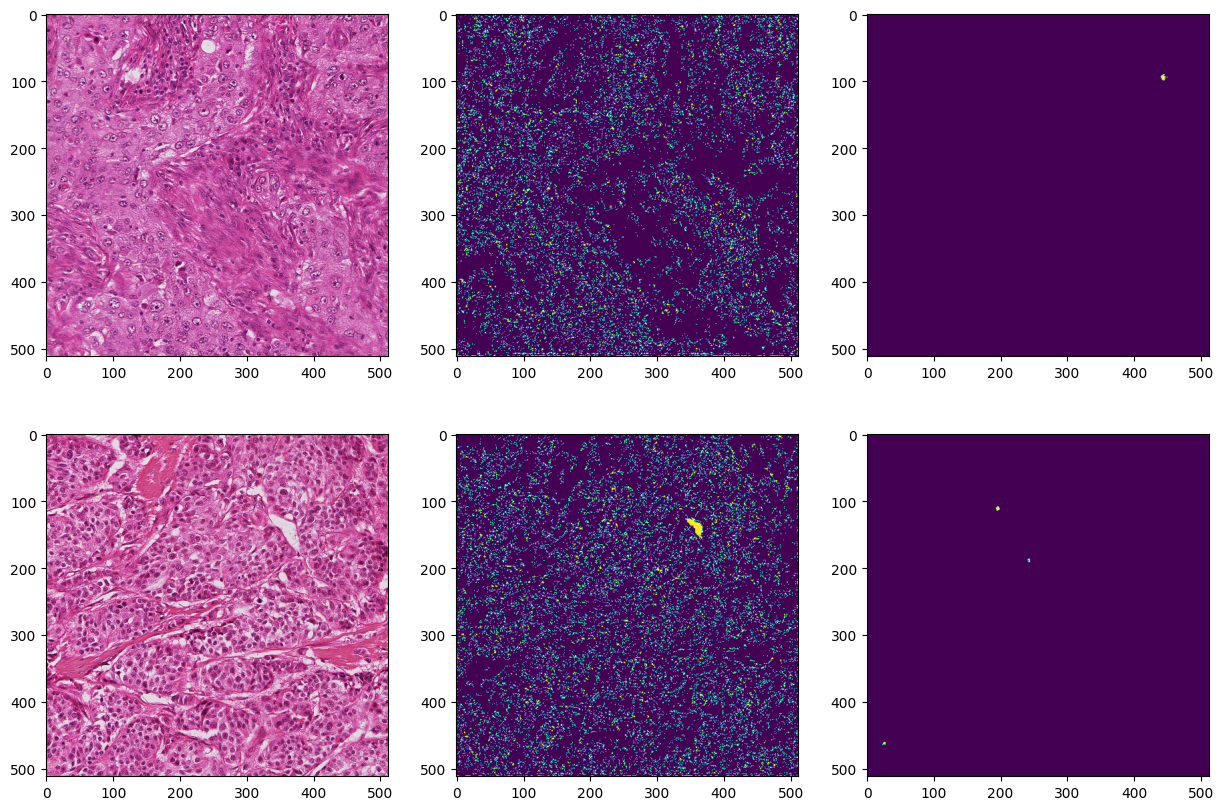

In [15]:
inputs, masks = next(iter(val_loader))
output        = ((torch.sigmoid(model(inputs.to('cuda')))) >0.5).float()
_, ax = plt.subplots(2,3, figsize=(15,10))
for k in range(2):
    ax[k][0].imshow(inputs[k].permute(1,2,0))
    ax[k][1].imshow(output[k][0].cpu())
    ax[k][2].imshow(masks[k])

In [1]:
import argparse
import logging
import os

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import glob
import sys
sys.path.append('/home/vinod/Documents/mitosis_detection/src/models/UNet')
from utils.data_loading import MitosisDataset
from unet import UNet
from utils.utils import plot_img_and_mask

In [2]:
def predict_img(net,
                full_img,
                device,
                img_size=512,
                out_threshold=0.5):
    net.eval()
    img = torch.from_numpy(MitosisDataset.preprocess(None, full_img, img_size, is_mask=False))
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img).cpu()
        output = F.interpolate(output, (full_img.size[1], full_img.size[0]), mode='bilinear')
        if net.n_classes > 1:
            mask = output.argmax(dim=1)
        else:
            mask = torch.sigmoid(output) > out_threshold

    return mask[0].long().squeeze().numpy()

In [3]:
def get_output_filenames(args):
    def _generate_name(fn):
        return f'{os.path.splitext(fn)[0]}_OUT.png'

    return args.output or list(map(_generate_name, args.input))

In [4]:
def mask_to_image(mask: np.ndarray, mask_values):
    if isinstance(mask_values[0], list):
        out = np.zeros((mask.shape[-2], mask.shape[-1], len(mask_values[0])), dtype=np.uint8)
    elif mask_values == [0, 1]:
        out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=bool)
    else:
        out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=np.uint8)

    if mask.ndim == 3:
        mask = np.argmax(mask, axis=0)

    for i, v in enumerate(mask_values):
        out[mask == i] = v

    return Image.fromarray(out)

In [9]:
class Args:
    def __init__(self):
        self.model = '/home/vinod/Documents/mitosis_detection/models/UNet/version1.0/checkpoint_epoch10.pth'
        self.input = [file for file in glob.glob('/data1/vinod/mitosis/data/processed/val/input' + '/**/*', recursive=True) if not os.path.isdir(file)]
        self.output = 'reports/figures'
        self.viz = False
        self.no_save = False
        self.mask_threshold = 0.5
        self.img_size = 512
        self.bilinear = False
        self.classes = 2

In [10]:
args = Args()
in_files = args.input
out_files = get_output_filenames(args)

net = UNet(n_channels=3, n_classes=args.classes, bilinear=args.bilinear)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device=device)
state_dict = torch.load(args.model, map_location=device)
mask_values = state_dict.pop('mask_values', [0, 1])
net.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for UNet:
	size mismatch for outc.conv.weight: copying a param with shape torch.Size([1, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
	size mismatch for outc.conv.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([2]).

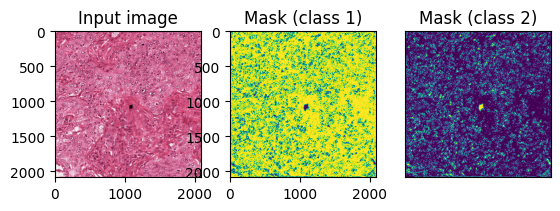

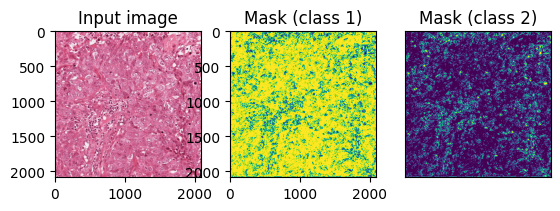

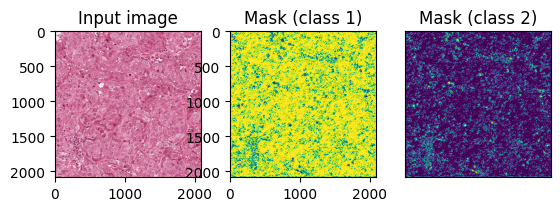

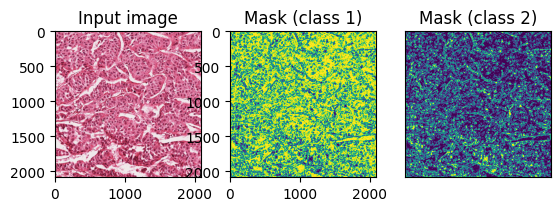

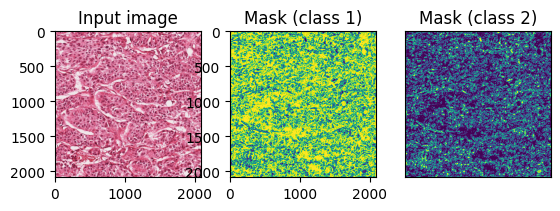

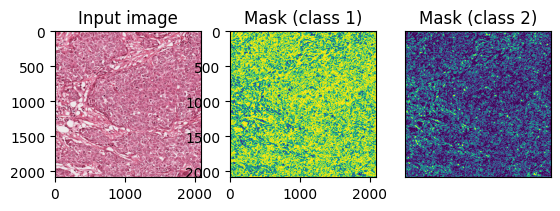

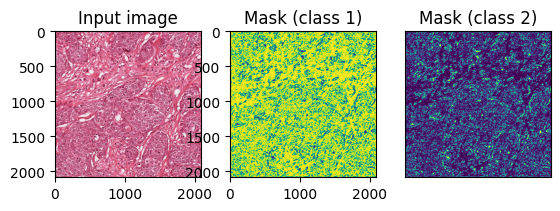

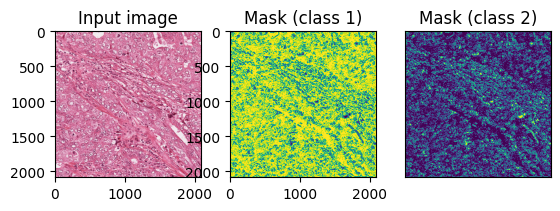

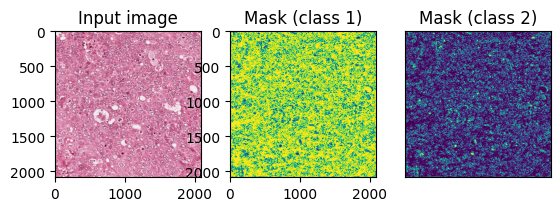

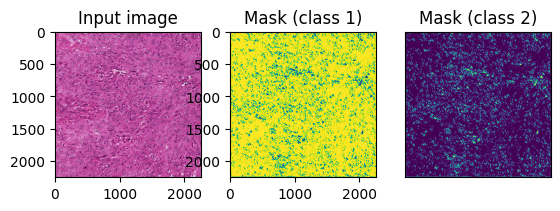

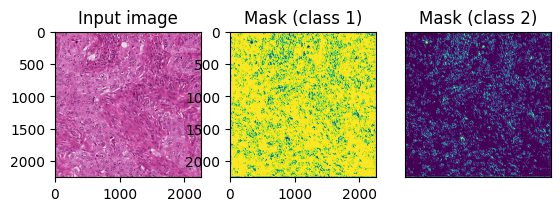

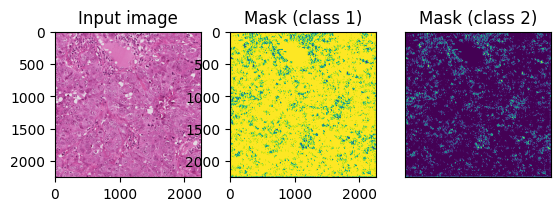

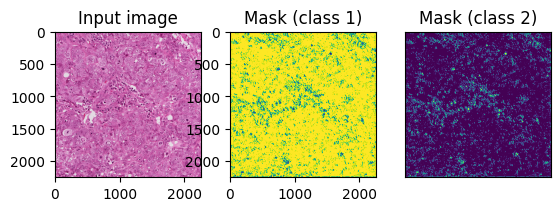

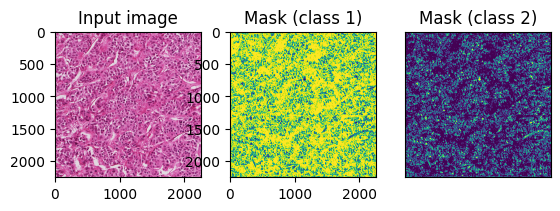

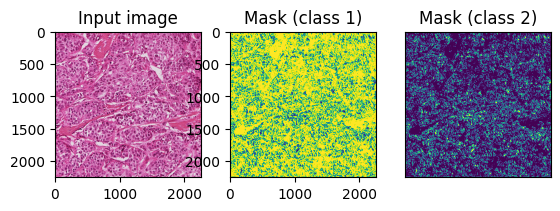

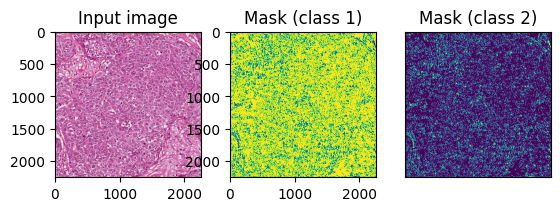

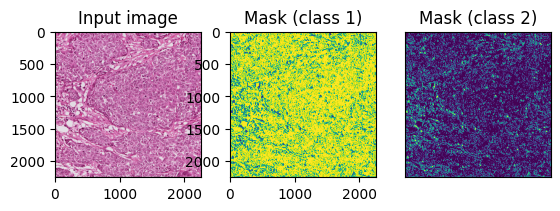

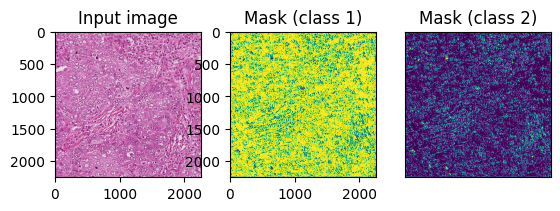

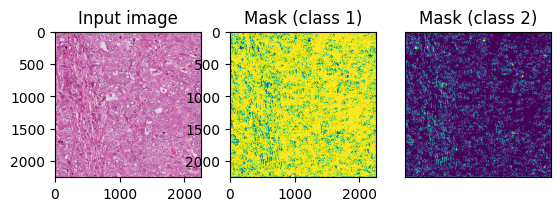

In [8]:
for i, filename in enumerate(in_files):
    img = Image.open(filename)

    mask = predict_img(net=net,
                        full_img=img,
                        img_size=args.img_size,
                        out_threshold=args.mask_threshold,
                        device=device)
    plot_img_and_mask(img, mask)